In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.metrics import r2_score, roc_auc_score

# !pip install feature_engine
import feature_engine as fe
from colorama import Fore, Back, Style

import xgboost
import random
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression, HuberRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import WoEEncoder
from sklearn.metrics import roc_auc_score

sns.set()

warnings.filterwarnings("ignore")


#### Read the data

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")


#### Understanding the data

In [4]:
display(train.head())

print(f'Train data shape is = {train.shape}')
print(f'Test data shape is = {test.shape}')

print("\n")

print(
    f'Train data missing value is = {format(100* train.isna().sum().sum()/(len(train)*25))}')
print(
    f'Test data missing value is  = {format(100* test.isna().sum().sum()/(len(test)*25))}')


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


Train data shape is = (26570, 26)
Test data shape is = (20775, 25)


Train data missing value is = 3.052013549115544
Test data missing value is  = 3.0245968712394706


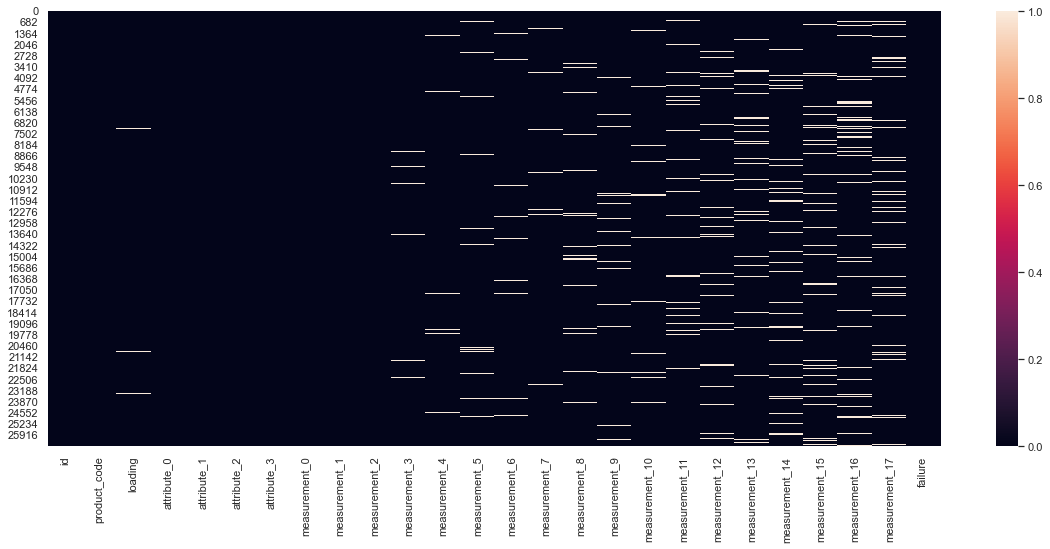

In [6]:
# plt.figure(figsize=(20,8))
sns.set(rc={"figure.figsize": (20, 8)})
sns.heatmap(train.isnull())
plt.show()


1. Most of the measurement features have null values

### Feature Distribution

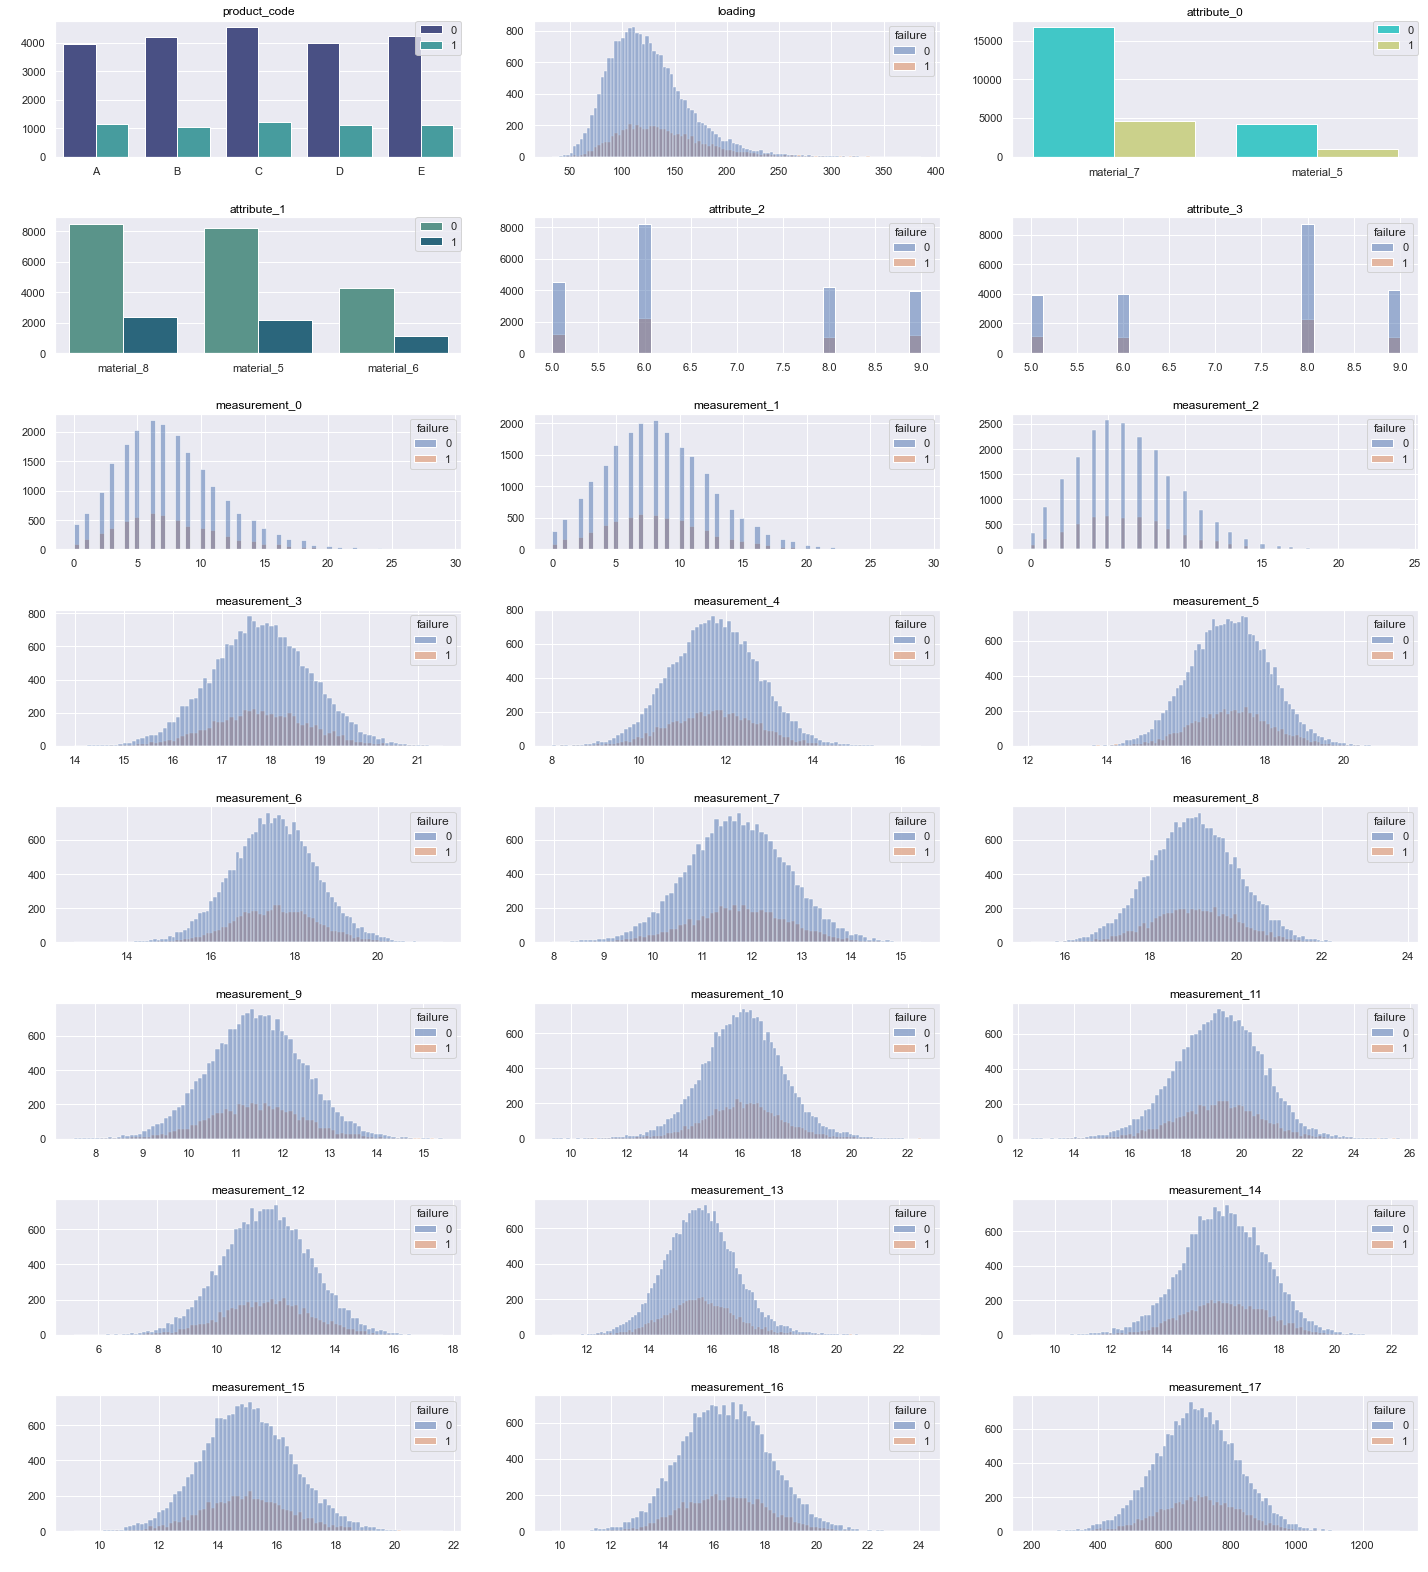

In [7]:
plt.style.use("fivethirtyeight")
useful_cols = [col for col in train.columns if col not in ["id", "failure"]]
cols_dist = [col for col in useful_cols if train[col].dtypes not in ['object']]
color_ = ['#9D2417', '#AF41B4', '#003389', '#3C5F41',  '#967032', '#2734DE']
cmap_ = ['mako', 'rainbow', 'crest']

sns.set(rc={"figure.figsize": (20, 22)})
for i, col in enumerate(train[useful_cols].columns):
    rand_col = color_[random.sample(range(6), 1)[0]]
    plt.subplot(8, 3, i + 1)
    if col in cols_dist:

        sns.histplot(
            data=train, x=train[col], hue=train['failure'], color=rand_col, fill=rand_col)
        plt.title(col, color='black')
        plt.ylabel(" ")
        plt.xlabel(" ")
        plt.tight_layout()
    else:
        sns.countplot(data=train, x=col, hue=train['failure'], palette=cmap_[
                      random.sample(range(3), 1)[0]])
        plt.title(col, color='black')
        plt.ylabel(" ")
        plt.xlabel(" ")
        plt.legend(loc='upper right', borderaxespad=0)
        plt.tight_layout()


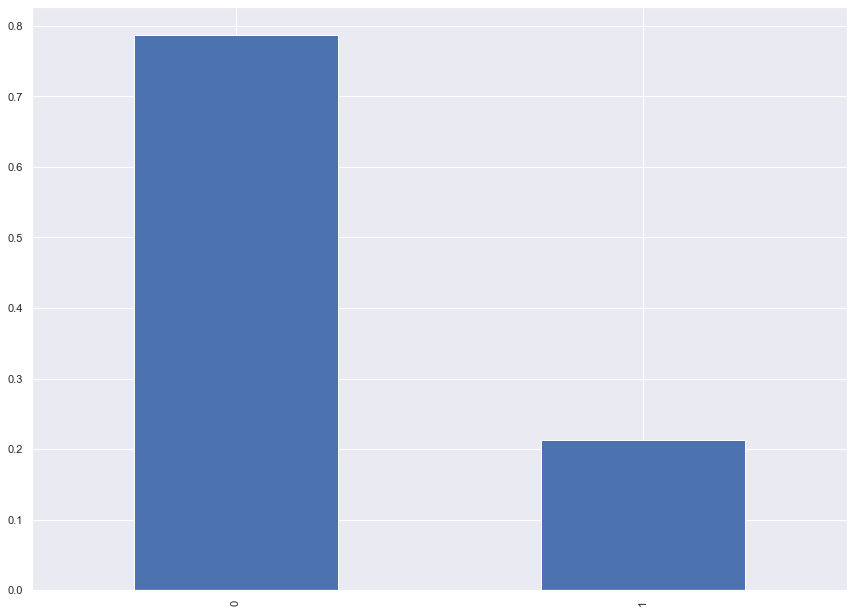

In [9]:
# class distribution
# 0 - not failed 1 - failed
sns.set(rc={"figure.figsize": (13, 10)})
train['failure'].value_counts(normalize=True).plot(kind='bar')
plt.show()


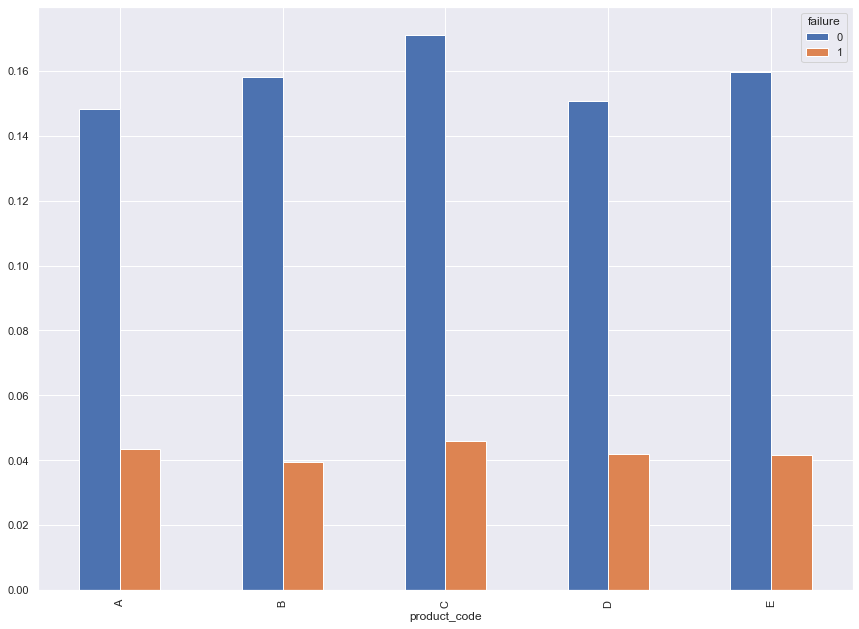

In [10]:
pd.crosstab(train['product_code'], train['failure'],
            normalize=True).plot(kind='bar')
plt.show()
# so we have approximately equal distribution of classes accross different product type


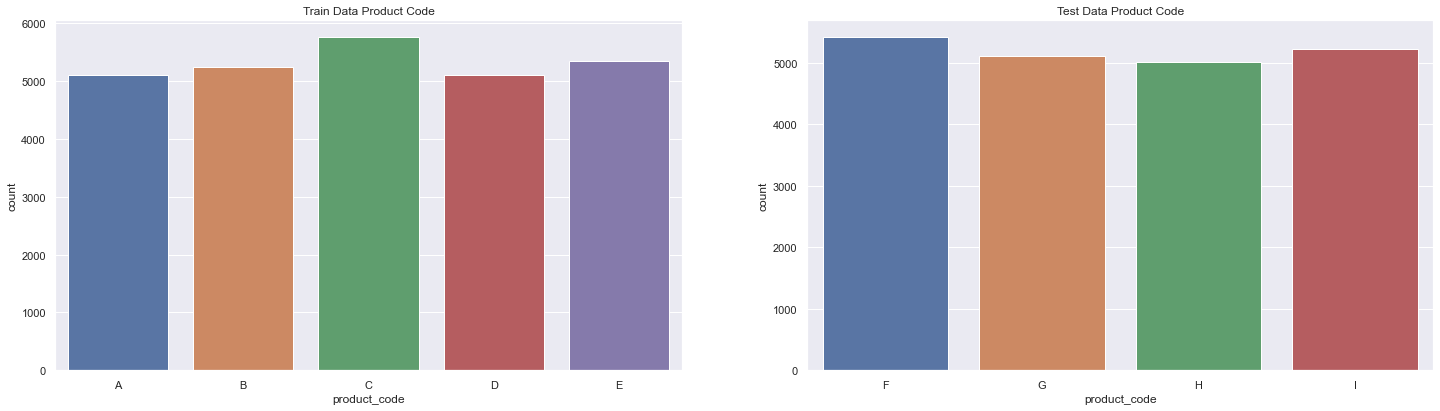

In [11]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
sns.countplot(train['product_code'])
plt.title("Train Data Product Code")
plt.subplot(1, 2, 2)
sns.countplot(test['product_code'])
plt.title("Test Data Product Code")
plt.show()

# product code is different in train and test data


### Note: 
As per this [discussion](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/342403) 
The public LB only compose of product code F data and rest product code G,H,I data in private LB.
To support this see below data. This is just an **assumption** we are making and so just believe in **cross validation technique**.


In [12]:
display(pd.DataFrame(test['product_code'].value_counts(normalize=True)))


,product_code
F,0.260987
I,0.251649
G,0.245824
H,0.241540


In [13]:
cat_feat = list()
num_feat = list()
for col in train.columns:
    if col in ['failure', 'id']:
        continue
    if train[col].dtype == "O":
        cat_feat.append(col)
    else:
        num_feat.append(col)


In [17]:
# corr = train[train['product_code']=='A'].corr()['measurement_0'].sort_values(ascending=False)


### Loading Feature 

The loading feature seems to have right skewed distribution.

Let's apply log transformation to make the distribution more normal.

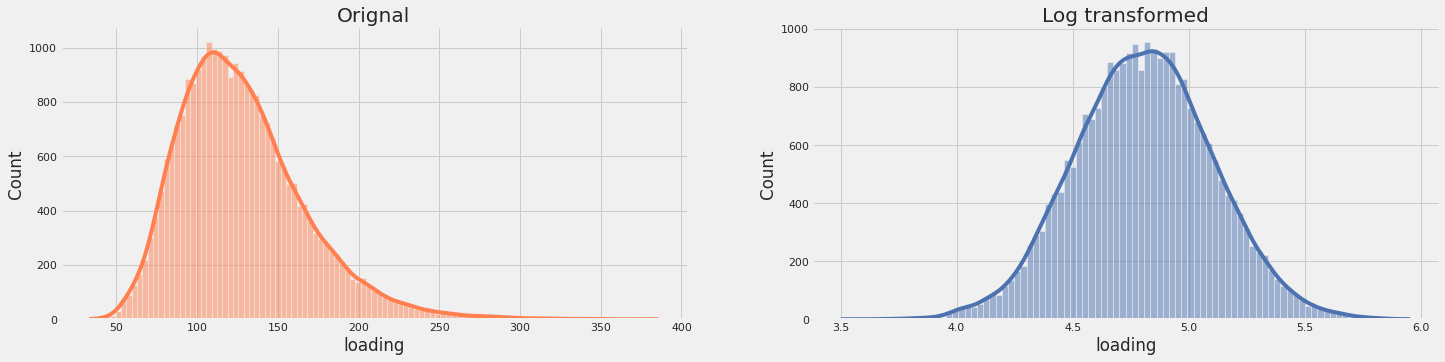

In [12]:
# training data

plt.figure(figsize=(22, 5))
plt.subplot(1, 2, 1)
sns.histplot(train['loading'], kde=True, color='coral')
plt.title("Orignal")
plt.subplot(1, 2, 2)
sns.histplot(np.log(train["loading"]), kde=True)
plt.title("Log transformed")
sns.despine()


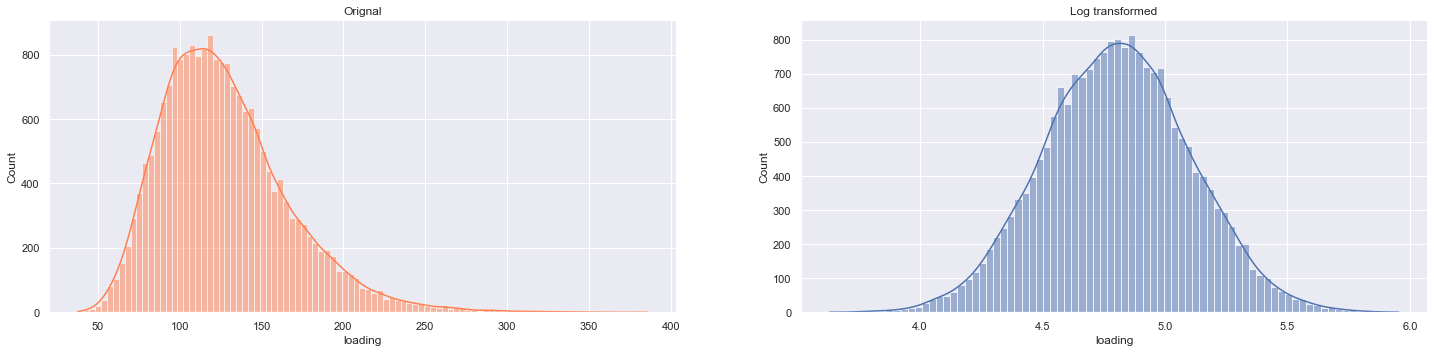

In [18]:
# testing data

plt.figure(figsize=(22, 5))
plt.subplot(1, 2, 1)
sns.histplot(test['loading'], kde=True, color='coral')
plt.title("Orignal")
plt.subplot(1, 2, 2)
sns.histplot(np.log(test["loading"]), kde=True)
plt.title("Log transformed")
sns.despine()


In [19]:
target = train.pop('failure')
target_mean = np.mean(target)
print(f"target mean --> {target_mean}")
data = pd.concat([train, test])
train.shape, test.shape


target mean --> 0.21260820474219044


((26570, 25), (20775, 25))

In [20]:
data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
data['area'] = data['attribute_2'] * data['attribute_3']

data['loading'] = np.log(data['loading'])
data['count_null'] = data.isnull().sum(axis=1)

nan_feat = list()
for col in train.columns:
    if train[col].isnull().sum() > 0:
        nan_feat.append(col)
        data["nan_"+col] = data[col].isnull().map(lambda k: 1 if k else 0)


feature = [f for f in test.columns if f.startswith('measurement') or f == 'loading']


### Preprocessing : Filling Missing Values + Encoding Categorical Variable using WeightofEvidence Technique

In [21]:
full_fill_dict = {}
full_fill_dict['measurement_17'] = {
    'A': ['measurement_5', 'measurement_6', 'measurement_8'],
    'B': ['measurement_4', 'measurement_5', 'measurement_7'],
    'C': ['measurement_5', 'measurement_7', 'measurement_8', 'measurement_9'],
    'D': ['measurement_5', 'measurement_6', 'measurement_7', 'measurement_8'],
    'E': ['measurement_4', 'measurement_5', 'measurement_6', 'measurement_8'],
    'F': ['measurement_4', 'measurement_5', 'measurement_6', 'measurement_7'],
    'G': ['measurement_4', 'measurement_6', 'measurement_8', 'measurement_9'],
    'H': ['measurement_4', 'measurement_5', 'measurement_7', 'measurement_8', 'measurement_9'],
    'I': ['measurement_3', 'measurement_7', 'measurement_8']
}


# collect the name of the next 10 best measurement columns sorted by correlation (except 17 already done above):
col = [col for col in test.columns if 'measurement' not in col] + \
    ['loading', 'm3_missing', 'm5_missing']
a = []
b = []

for x in range(3, 17):
    corr = np.absolute(data.drop(col, axis=1).corr()[
                       f'measurement_{x}']).sort_values(ascending=False)
    # we add the 3 first lines of the correlation values to get the "most correlated"
    a.append(np.round(np.sum(corr[1:4]), 3))
    b.append(f'measurement_{x}')
c = pd.DataFrame()
c['Selected columns'] = b
c['correlation total'] = a


In [22]:
c = c.sort_values(by='correlation total',
                  ascending=False).reset_index(drop=True)
print(f'Columns selected by correlation sum of the 3 first rows : ')
display(c.head(10))


Columns selected by correlation sum of the 3 first rows : 


,Selected columns,correlation total
0,measurement_8,0.448
1,measurement_11,0.395
2,measurement_5,0.376
3,measurement_6,0.359
4,measurement_4,0.338
5,measurement_7,0.330
6,measurement_15,0.301
7,measurement_10,0.300
8,measurement_16,0.252
9,measurement_14,0.225


In [24]:
# calculating top 4 correlated features for each measurement column w.r.t each product code

for i in range(10):
    # we select the next best correlated column
    measurement_col = 'measurement_' + c.iloc[i, 0][12:]
    fill_dict = {}
    for x in data.product_code.unique():
        corr = np.absolute(data[data.product_code == x].drop(col, axis=1).corr()[measurement_col]).sort_values(ascending=False)

        measurement_col_dic = {}
        measurement_col_dic[measurement_col] = corr[1:5].index.tolist()
        fill_dict[x] = measurement_col_dic[measurement_col]

    full_fill_dict[measurement_col] = fill_dict


In [25]:
feature = [f for f in data.columns if f.startswith(
    'measurement') or f == 'loading']
nullValue_cols = [
    col for col in train.columns if train[col].isnull().sum() != 0]


In [26]:
# Filling NA values using HuberRegressor & KNNImputer
# HuberRegressor is used when except for target feature all other correlated feature column has no null values i.e
# for e.g. for measurement_17 product_code A correlated feature is ['measurement_5','measurement_6','measurement_8']
# Then HuberRegressor will be used on those samples where ['measurement_5','measurement_6','measurement_8'] columns has
# no null values
# If above condition doesn't satisfy then we apply KNNImputer

for code in data.product_code.unique():
    total_na_filled_by_linear_model = 0
    print(f'\n-------- Product code {code} ----------\n')
    print(f'filled by linear model :')
    for measurement_col in list(full_fill_dict.keys()):
        tmp = data[data.product_code == code]
        column = full_fill_dict[measurement_col][code]
        tmp_train = tmp[column+[measurement_col]].dropna(how='any')
        tmp_test = tmp[(tmp[column].isnull().sum(axis=1) == 0)
                       & (tmp[measurement_col].isnull())]

        model = HuberRegressor(epsilon=1.9)
        model.fit(tmp_train[column], tmp_train[measurement_col])
        data.loc[(data.product_code == code) & (data[column].isnull().sum(axis=1) == 0)
                 & (data[measurement_col].isnull()), measurement_col] = model.predict(tmp_test[column])
        print(f'{measurement_col} : {len(tmp_test)}')
        total_na_filled_by_linear_model += len(tmp_test)

    # others NA columns:
    NA = data.loc[data["product_code"] == code,
                  nullValue_cols].isnull().sum().sum()
    model1 = KNNImputer(n_neighbors=3)
    data.loc[data.product_code == code, feature] = model1.fit_transform(
        data.loc[data.product_code == code, feature])
    print(f'\n{total_na_filled_by_linear_model} filled by linear model ')
    print(f'{NA} filled by KNN ')



-------- Product code A ----------

filled by linear model :
measurement_17 : 386
measurement_8 : 175
measurement_11 : 225
measurement_5 : 134
measurement_6 : 155
measurement_4 : 89
measurement_7 : 176
measurement_15 : 273
measurement_10 : 211
measurement_16 : 293
measurement_14 : 237

2354 filled by linear model 
1495 filled by KNN 

-------- Product code B ----------

filled by linear model :
measurement_17 : 418
measurement_8 : 170
measurement_11 : 220
measurement_5 : 90
measurement_6 : 128
measurement_4 : 84
measurement_7 : 176
measurement_15 : 294
measurement_10 : 197
measurement_16 : 358
measurement_14 : 339

2474 filled by linear model 
1501 filled by KNN 

-------- Product code C ----------

filled by linear model :
measurement_17 : 391
measurement_8 : 218
measurement_11 : 231
measurement_5 : 148
measurement_6 : 154
measurement_4 : 110
measurement_7 : 151
measurement_15 : 342
measurement_10 : 268
measurement_16 : 343
measurement_14 : 340

2696 filled by linear model 
1648 fill

In [27]:
data['measurement_avg'] = data[[
    f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)
df_train = data.iloc[:train.shape[0], :]
df_test = data.iloc[train.shape[0]:, :]

woe_encoder = WoEEncoder(variables=['attribute_0'])
woe_encoder.fit(df_train, target)
df_train = woe_encoder.transform(df_train)
df_test = woe_encoder.transform(df_test)


In [28]:
df_train['measurement(3*5)'] = df_train['measurement_3'] * \
    df_train['measurement_5']
df_test['measurement(3*5)'] = df_test['measurement_3'] * \
    df_test['measurement_5']

df_train['missing(3*5)'] = df_train['m5_missing'] * (df_train['m3_missing'])
df_test['missing(3*5)'] = df_test['m5_missing'] * (df_test['m3_missing'])


In [29]:
features = ['loading', 'attribute_0', 'measurement_17', 'measurement_0', 'measurement_1', 'measurement_2', 'count_null', 'area', 'm3_missing', 'm5_missing',
            'measurement_avg', 'measurement(3*5)', 'missing(3*5)']

"""
'nan_loading', 'nan_measurement_3', 
        'nan_measurement_4','nan_measurement_5', 'nan_measurement_6', 'nan_measurement_7',
       'nan_measurement_8', 'nan_measurement_9', 'nan_measurement_10',
       'nan_measurement_11', 'nan_measurement_12', 'nan_measurement_13',
       'nan_measurement_14', 'nan_measurement_15', 'nan_measurement_16',
       'nan_measurement_17',

"""
df_train['failure'] = target


### Standard Scaler

In [30]:
def scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_data[feats])
    scaled_val = scaler.transform(val_data[feats])
    scaled_test = scaler.transform(test_data[feats])
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    return new_train, new_val, new_test


### Logistic Regression

******* Fold 0 ******* 
VAL_ROC-AUC: 0.58737
******* Fold 1 ******* 
VAL_ROC-AUC: 0.59246
******* Fold 2 ******* 
VAL_ROC-AUC: 0.59414
******* Fold 3 ******* 
VAL_ROC-AUC: 0.59129
******* Fold 4 ******* 
VAL_ROC-AUC: 0.5831
Average auc = 0.58967
OOF auc = 0.58966


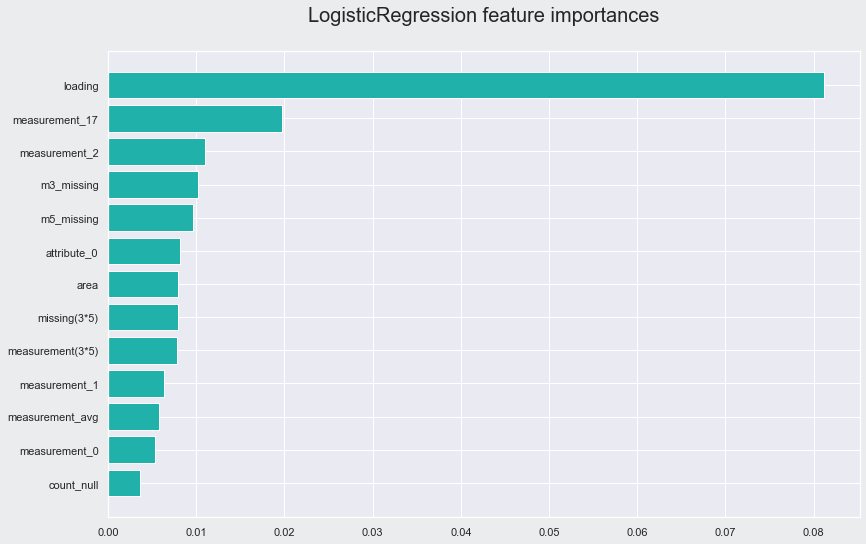

In [31]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=22)
y_oof = np.zeros(df_train[features].shape[0])
y_test = np.zeros(df_test[features].shape[0])
logistic_auc = 0
ix = 0
feature_importance = []
catboost_model = []


for train_ind, val_ind in skf.split(df_train[features], df_train[['failure']]):
    print(f"******* Fold {ix} ******* ")
    tr_x, val_x = (
        df_train[features].iloc[train_ind].reset_index(drop=True),
        df_train[features].iloc[val_ind].reset_index(drop=True),
    )
    tr_y, val_y = (
        df_train['failure'].iloc[train_ind].reset_index(drop=True),
        df_train['failure'].iloc[val_ind].reset_index(drop=True),
    )

    tr_x, val_x, test_x = scale(tr_x, val_x, df_test[features], features)

    clf = LogisticRegression(max_iter=500, C=0.0001,
                             penalty='l2', solver='newton-cg')

    clf.fit(tr_x, tr_y)
    feature_importance.append(clf.coef_.ravel())
    preds = clf.predict_proba(val_x)[:, 1]

    roc_score = roc_auc_score(val_y, preds)

    logistic_auc += roc_score/5

    print('VAL_ROC-AUC:', round(roc_score, 5))

    y_oof[val_ind] = y_oof[val_ind] + preds

    preds_test = clf.predict_proba(test_x)[:, 1]
    y_test = y_test + preds_test / N_FOLDS
    ix = ix + 1

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(logistic_auc, 5)}{Style.RESET_ALL}")
print(
    f"{Fore.BLUE}{Style.BRIGHT}OOF auc = {round(roc_auc_score(df_train[['failure']], y_oof), 5)}{Style.RESET_ALL}")

feature_importance.append(clf.coef_.ravel())
importance_df = pd.DataFrame(
    np.array(feature_importance).T, index=df_train[features].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = df_train[features].columns
importance_df = importance_df.sort_values('mean', ascending=True).reset_index()

fig, ax = plt.subplots(figsize=(12, 8), facecolor='#EAECEE')
plt.barh(importance_df.index, importance_df['mean'], color='lightseagreen')

plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances', fontsize=20, y=1.05)
plt.show()


In [32]:
y_pred = df_train[['failure']].copy(deep=True)
y_pred = y_pred.rename(columns={"failure": "prediction"})
y_pred["prediction"] = y_oof

roc_auc_score(df_train[['failure']], y_pred)


0.5896578509369165

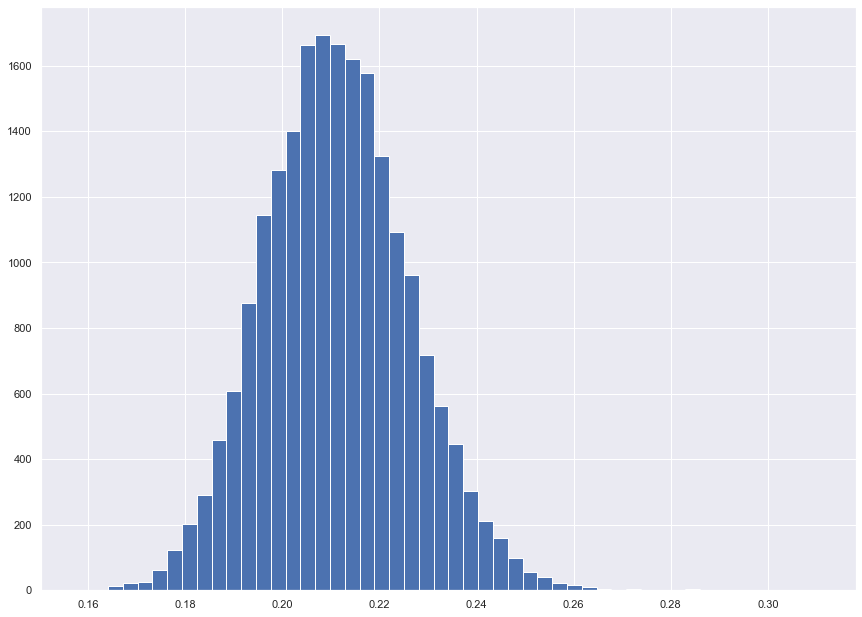

In [33]:
# distribution of scores on test data -- logistic regression model
plt.hist(y_test, bins=50)
plt.show()


In [35]:
sub_log = pd.read_csv('../data/sample_submission.csv')
sub_log['failure'] = preds_test

sub_log.to_csv("../data/solution.csv", index=False)
# Public Score: 0.59172
